In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
root_dir = '../'
sys.path.append(root_dir)

In [3]:
import pandas as pd

from data import build_train_val_loaders
#from utils import load_mask, stratified_split

In [4]:
data_path = '../data/competition_data/'
test_imgs = pd.read_csv(data_path+'sample_submission.csv')
train_df = pd.read_csv(data_path+'train.csv')


In [5]:
batch_size= 128
tloader, vloader = build_train_val_loaders(data_path, batch_size)

In [6]:
from model import init_model
unet = init_model(from_scratch=True)

In [15]:
from trainer import train_epochs
import torch.nn as nn

loss_fn = nn.BCEWithLogitsLoss()
saved_path = '../saved_models/'
losses, ious, best_model = train_epochs(tloader, vloader, unet, loss_fn, 10, saved_path)

----------
Epoch 1/10
 100.0 %	loss   0.2039	IoU   0.7171	0m 16s
Validation: 	loss   0.1789 	IoU   0.7159
Score increased (inf --> 0.715891).  Saving model ...
----------
Epoch 2/10
 100.0 %	loss   0.1796	IoU   0.7446	0m 36s
Validation: 	loss   0.1945 	IoU   0.7459
Score increased (0.715891 --> 0.745941).  Saving model ...
----------
Epoch 3/10
 100.0 %	loss   0.1796	IoU   0.7432	0m 55s
Validation: 	loss   0.1892 	IoU   0.7297
EarlyStopping counter: 1 out of 15
----------
Epoch 4/10
 100.0 %	loss   0.1699	IoU   0.7510	1m 13s
Validation: 	loss   0.1441 	IoU   0.7706
Score increased (0.745941 --> 0.770609).  Saving model ...
----------
Epoch 5/10
 100.0 %	loss   0.1618	IoU   0.7636	1m 33s
Validation: 	loss   0.2076 	IoU   0.7122
EarlyStopping counter: 1 out of 15
----------
Epoch 6/10
 100.0 %	loss   0.1657	IoU   0.7546	1m 52s
Validation: 	loss   0.1508 	IoU   0.7807
Score increased (0.770609 --> 0.780749).  Saving model ...
----------
Epoch 7/10
 100.0 %	loss   0.1621	IoU   0.7677	2m 11

In [16]:
ious

([0.7336426973342896,
  0.7657186985015869,
  0.7472652196884155,
  0.7968200445175171,
  0.7984687685966492,
  0.7301192879676819,
  0.7263355851173401,
  0.7297784090042114,
  0.7629646062850952,
  0.7569572925567627],
 [0.715891145169735,
  0.7459408491849899,
  0.7297261878848076,
  0.7706090584397316,
  0.7121682316064835,
  0.7807487472891808,
  0.7456300482153893,
  0.7238490805029869,
  0.7760874256491661,
  0.7692949548363686])

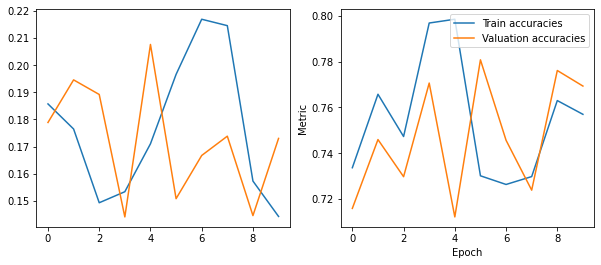

In [18]:
import matplotlib.pyplot as plt

# plot the train and val losses
fig = plt.figure(figsize=(10, 4))
tloss, vloss = losses
tiou, viou = ious

#plot losses
ax = fig.add_subplot(1, 2, 1)
ax.plot(tloss, label = 'Train loss')
ax.plot(vloss, label = 'Valuation loss')

#plot accuracies
ax = fig.add_subplot(1, 2, 2)
ax.plot(tiou, label='Train accuracies')
ax.plot(viou, label='Valuation accuracies')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
## https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

image_path = "test/images"
sub_df = pd.read_csv('../input/tgs-salt-identification-challenge/sample_submission.csv')
n = sub_df.shape[0]
model = init_model(from_scratch=False, best=True).to(device)
model.eval()

rle_mask = []
for idx in range(n):
    ## load image
    sample_name = sub_df['id'][idx]
    image = cv2.imread(os.path.join(image_path, sample_name+'.png'))
    oimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255
    oimg = cv2.resize(oimg, (128, 128))
    fimg = cv2.flip(oimg, 1)
    oimg = torch.tensor(oimg).unsqueeze(0).to(device)
    fimg = torch.tensor(fimg).unsqueeze(0).to(device)

    omask = model(oimg.unsqueeze(0).float())
    fmask = model(fimg.unsqueeze(0).float())

    omask = omask.squeeze().detach().cpu().numpy() 
    fmask = fmask.squeeze().detach().cpu().numpy()
    #print(fmask.shape)
    fmaskf = cv2.flip(fmask, 1)
    mask = (omask + fmaskf)/2.
    mask = cv2.resize(mask, (101, 101))
    pred = np.where(mask<0., 0, 1)
    #print(pred.shape)
    ## write mask
    rle_mask.append(rle_encode(pred))
    print("\rprogress {}/{}".format(idx+1, n), end = "")
    
sub_df['rle_mask'] = rle_mask
sub_df.to_csv('submission.csv', index = False)